In [102]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pyspark.sql import SparkSession, functions as F

from lightgbm import LGBMRegressor
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from pandas_profiling import ProfileReport
from rdkit import Chem
from rdkit.Chem.rdmolops import SanitizeFlags
from tqdm import tqdm
from xyz import xyz2mol, xyz2AC, AC2mol, read_xyz_file
from requests_toolbelt.multipart.encoder import MultipartEncoder

# Data loading

Apart from original data provided for this competition, we will also be using **RDKit** for creating additional chemical features for each molecule, and **NMR spectres Data Base** for some valuable features for predicting our target. We will also use **RDKit** to create **SMILES** representations of our molecules to build the TF-IDF features for our molecules.

First of all, all of this data must be read/downloaded.

In [2]:
train = pd.read_csv('molecules/train.csv')
test = pd.read_csv('molecules/test.csv')
structs = pd.read_csv('molecules/structures.csv')

In [10]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [11]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [12]:
structs.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [3]:
def get_nmr_spectre(molfilename):
    with open(molfilename) as file:
        data = file.read()

    mp_encoder = MultipartEncoder(fields={'molfile': data})
    headers = {'Content-Type': mp_encoder.content_type}
    res = requests.post(url="https://www.nmrdb.org/service/predictor", data=mp_encoder, headers=headers)
    return res.content.decode(encoding='utf-8')

def chiral_stereo_check(mol):
    # avoid sanitization error e.g., dsgdb9nsd_037900.xyz
    Chem.SanitizeMol(mol, SanitizeFlags.SANITIZE_ALL - SanitizeFlags.SANITIZE_PROPERTIES)
    Chem.DetectBondStereochemistry(mol,-1)
    # ignore stereochemistry for now
    #Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    #Chem.AssignAtomChiralTagsFromStructure(mol,-1)
    return mol


def xyz2mol(atomicNumList,charge,xyz_coordinates,charged_fragments,quick):
    AC,mol = xyz2AC(atomicNumList,xyz_coordinates)
    new_mol = AC2mol(mol,AC,atomicNumList,charge,charged_fragments,quick)
    new_mol = chiral_stereo_check(new_mol)
    return new_mol

def mol_from_xyz(filename):
    charged_fragments = True
    quick = True
    atomicNumList, charge, xyz_coordinates = read_xyz_file(filename)
    mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)
    return mol


def mols_from_folder(directory):
    molecules = {}
    for file in tqdm(os.listdir(directory)):
        molecules[file[:-4]] = mol_from_xyz(os.path.join(directory, file))
    return molecules

def get_smiles_for_mols(mols):
    return pd.DataFrame([(name, Chem.MolToSmiles(mols[name])) for name in mols.keys()], columns=['molecule_name', 'SMILES'])

def get_nmr_spectres(mols, cache_dir='nmr_cache', cache_freq=500):
    res = pd.DataFrame(columns=['molecule_name', 'raw_nmr'])
    cache = {}
    cache_num = 0
    os.makedirs(cache_dir, exist_ok=True)
    
    cached_files = [file for file in os.listdir(cache_dir) if file.endswith('.csv')]
    print('Reading cache from {} files'.format(len(cached_files)))
    for file in cached_files:
        res = pd.concat([res, pd.read_csv(os.path.join(cache_dir, file))[['molecule_name', 'raw_nmr']]])
    
    mols_to_read = {name: mols[name] for name in set(mols.keys()) - set(res['molecule_name'])}
    print('{} molecules will be downloaded, since {} were cached'.format(len(mols_to_read), res.shape[0]))
    
    for name, mol in mols_to_read.items():
        try:
            path = os.path.join('mols', name)
            Chem.MolToMolFile(mol, path)
            cache[name] = get_nmr_spectre(path)
        except Exception as e:
            print("Failed to load {}, error: {}".format(name, e.args[0]))
        
        if len(cache) >= cache_freq:
            print('Caching last {} molecules, total downloaded: {}'.format(cache_freq, len(res)))
            cache_df = pd.DataFrame(list(cache.items()), columns=['molecule_name', 'raw_nmr'])
            cache_df.to_csv(os.path.join(cache_dir, 'cache_{}.csv'.format(cache_num)))
            cache = {}
            cache_num += 1
            res = pd.concat([res, cache_df])
    
    cache_df = pd.DataFrame(list(cache.items()), columns=['molecule_name', 'raw_nmr'])
    cache_df.to_csv(os.path.join(cache_dir, 'cache_{}.csv'.format(cache_num)))
    res = pd.concat([res, cache_df])
    
    return res


def parse_raw_nmr(nmr_string):
    res = []
    for line in nmr_string.split('\n'):
        line = line.split('\t')
        if len(line) >= 3:
            res.append((int(line[0]) - 1, float(line[2])))
    return pd.DataFrame(res, columns=['atom_index_0', 'delta'])


def parse_all_nmrs(raw_nmr):
    nmr_dict = {item[1]: item[2] for item in raw_nmr.itertuples()}
    res = []
    for name in nmr_dict:
        pdf = parse_raw_nmr(nmr_dict[name])
        pdf['molecule_name'] = name
        res.append(pdf)
    return pd.concat(res)

Building the convenient **RDKit** represenations of our molecules:

In [4]:
mols = mols_from_folder('structures')

100%|██████████| 130775/130775 [07:03<00:00, 308.88it/s]


Downloading raw NMR spectres for the molecules (represented as strings), then parsing them to get the **delta** feature for each Hydrogen in each molecule:

In [5]:
raw_nmr = get_nmr_spectres(mols)

Reading cache from 261 files
500 molecules will be downloaded, since 130275 were cached
Caching last 500 molecules, total downloaded: 130275


In [6]:
parsed_nmrs = parse_all_nmrs(raw_nmr.dropna())

In [7]:
parsed_nmrs.head()

,atom_index_0,delta,molecule_name
0,9,8.207,dsgdb9nsd_025055
1,10,9.160,dsgdb9nsd_025055
2,11,2.839,dsgdb9nsd_025055
0,9,2.661,dsgdb9nsd_133073
1,10,2.661,dsgdb9nsd_133073


Creating **SMILES** representations for the molecules: 

In [8]:
smiles = get_smiles_for_mols(mols)

In [9]:
smiles.head()

,molecule_name,SMILES
0,dsgdb9nsd_046695,[H]N1C([H])([H])C(=O)C2([H])OC3([H])C1([H])C23[H]
1,dsgdb9nsd_073956,[H]C#CC1=C(C([H])([H])[H])C([H])([H])C([H])([H...
2,dsgdb9nsd_075970,[H]C([H])([H])N1C(=O)C([H])([H])C([H])([H])C([...
3,dsgdb9nsd_014749,[H]N(C([H])([H])C#N)C([H])([H])C([H])([H])C([H...
4,dsgdb9nsd_037068,[H]C1([H])OC23C([H])([H])C([H])([H])C([H])([H]...


# Feature aggregation

Building a TF-IDF vectorizer based on text (only for 2-sized NGrams, so that the TF-IDF will be based on atoms' connections counts):

In [13]:
tokenizer = lambda smiles: list(smiles)

tfidf = TfidfVectorizer(stop_words=[']', '[', 'n', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'h', 'c', 'o', '(', ')', '\\', '/', '#', '=', '-', '+', '.'], tokenizer=tokenizer, ngram_range=[2, 2], max_features=200, lowercase=False)
smiles_tfidf = tfidf.fit_transform(smiles['SMILES'])
smiles_tfidf = pd.DataFrame(smiles_tfidf.todense(), columns=tfidf.get_feature_names())
smiles_tfidf['molecule_name'] = smiles['molecule_name']

In [14]:
smiles_tfidf.head()

,C C,C F,C H,C N,C O,F C,F F,F H,F N,F O,...,N F,N H,N N,N O,O C,O F,O H,O N,O O,molecule_name
0,0.000000,0.0,0.673586,0.000000,0.251335,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.349252,0.0,0.0,0.0,0.0,dsgdb9nsd_046695
1,0.663556,0.0,0.408271,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.132304,0.0,0.0,0.0,0.0,dsgdb9nsd_073956
2,0.000000,0.0,0.473376,0.000000,0.441577,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.153402,0.0,0.0,0.0,0.0,dsgdb9nsd_075970
3,0.000000,0.0,0.493389,0.248323,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,dsgdb9nsd_014749
4,0.324194,0.0,0.598408,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.129280,0.0,0.0,0.0,0.0,dsgdb9nsd_037068


In [16]:
def atom_features(atom):
    prop = {}
    nb = [a.GetSymbol() for a in atom.GetNeighbors()] # neighbor atom type symbols
    nb_h = sum([_ == 'H' for _ in nb]) # number of hydrogen as neighbor
    nb_o = sum([_ == 'O' for _ in nb]) # number of oxygen as neighbor
    nb_c = sum([_ == 'C' for _ in nb]) # number of carbon as neighbor
    nb_n = sum([_ == 'N' for _ in nb]) # number of nitrogen as neighbor
    nb_na = len(nb) - nb_h - nb_o - nb_n - nb_c
    prop['degree'] = atom.GetDegree()
    prop['hybridization'] = int(atom.GetHybridization())
    prop['inring'] = int(atom.IsInRing()) # is the atom in a ring?
    prop['inring3'] = int(atom.IsInRingSize(3)) # is the atom in a ring size of 3?
    prop['inring4'] = int(atom.IsInRingSize(4)) # is the atom in a ring size of 4?
    prop['inring5'] = int(atom.IsInRingSize(5)) # ...
    prop['inring6'] = int(atom.IsInRingSize(6))
    prop['inring7'] = int(atom.IsInRingSize(7))
    prop['inring8'] = int(atom.IsInRingSize(8))
    prop['nb_h'] = nb_h
    prop['nb_o'] = nb_o
    prop['nb_c'] = nb_c
    prop['nb_n'] = nb_n
    prop['nb_na'] = nb_na
    return prop


def rdkit_features(mols):
    res = []
    for name, mol in tqdm(list(mols.items())):
        res += [{'molecule_name': name, 'atom_index': i, **atom_features(mol.GetAtomWithIdx(i))} for i in range(mol.GetNumAtoms())]
    return pd.DataFrame(res)

Let's build some **RDKit** chemical features, such as degree of every atom, it's hybridization, numbers of atoms of each types it is connected to and flags which tell if this atom is participating in rings of different sizes:

In [17]:
rdkit_feats = rdkit_features(mols)

100%|██████████| 130775/130775 [00:34<00:00, 3779.82it/s]


In [18]:
rdkit_feats.head()

,molecule_name,atom_index,degree,hybridization,inring,inring3,inring4,inring5,inring6,inring7,inring8,nb_h,nb_o,nb_c,nb_n,nb_na
0,dsgdb9nsd_046695,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0
1,dsgdb9nsd_046695,1,3,3,1,0,0,0,1,0,0,0,1,2,0,0
2,dsgdb9nsd_046695,2,4,4,1,0,0,0,1,0,0,2,0,1,1,0
3,dsgdb9nsd_046695,3,3,4,1,0,0,0,1,0,0,1,0,2,0,0
4,dsgdb9nsd_046695,4,4,4,1,1,0,0,1,0,0,1,0,2,1,0


## Features built from the original competition data:

Now let's proceed to use our original competition data to build some more features with it:

In [96]:
MASS_MAPPING = {'C': 12, 'N': 14, 'H': 1}


def vector_length_from_cols(df, cols):
    return sum([df[col]**2 for col in cols]) ** 0.5


def add_distances(molecules_df, structs_df):
    molecules_df = molecules_df\
        .merge(structs_df.rename({'atom_index': 'atom_index_0', 'x': 'x_0', 'y': 'y_0', 'z': 'z_0', 'atom': 'atom_0'}, axis=1)[['molecule_name', 'atom_index_0', 'x_0', 'y_0', 'z_0', 'atom_0']], on=['molecule_name', 'atom_index_0'])\
        .merge(structs_df.rename({'atom_index': 'atom_index_1', 'x': 'x_1', 'y': 'y_1', 'z': 'z_1', 'atom': 'atom_1'}, axis=1)[['molecule_name', 'atom_index_1', 'x_1', 'y_1', 'z_1', 'atom_1']], on=['molecule_name', 'atom_index_1'])
    molecules_df['distance'] = (sum([(molecules_df['{}_0'.format(col)] - molecules_df['{}_1'.format(col)]) ** 2 for col in ['x', 'y', 'z']])) ** 0.5
    
    molecules_df = molecules_df.merge(molecules_df.groupby(['molecule_name', 'atom_index_0'])['distance'].mean().rename('mean_distance_0').reset_index(), on=['molecule_name', 'atom_index_0'])
    molecules_df = molecules_df.merge(molecules_df.groupby(['molecule_name', 'atom_index_1'])['distance'].mean().rename('mean_distance_1').reset_index(), on=['molecule_name', 'atom_index_1'])
    
    return molecules_df


def add_sizes(molecules_df, structs_df):
    sizes = (structs_df.groupby('molecule_name')['atom_index'].max() + 1).reset_index().rename({'atom_index': 'size'}, axis=1)
    return molecules_df.merge(sizes, on='molecule_name')


def add_connections(molecules_df):
    left = molecules_df.groupby(['molecule_name', 'atom_index_0']).size().rename('connection_0').reset_index().rename({'atom_index_0': 'atom_index'}, axis=1)
    right = molecules_df.groupby(['molecule_name', 'atom_index_1']).size().rename('connection_1').reset_index().rename({'atom_index_1': 'atom_index'}, axis=1)
    connections = left.merge(right, on=['molecule_name', 'atom_index'], how='outer').fillna(0)
    connections['connections'] = connections['connection_0'] + connections['connection_1']
    connections.drop(['connection_0', 'connection_1'], axis=1, inplace=True)
    
    molecules_df = molecules_df.merge(connections.rename({'atom_index': 'atom_index_0', 'connections': 'connections_0'}, axis=1), on=['molecule_name', 'atom_index_0'])
    molecules_df = molecules_df.merge(connections.rename({'atom_index': 'atom_index_1', 'connections': 'connections_1'}, axis=1), on=['molecule_name', 'atom_index_1'])
    return molecules_df


def add_weights(molecules_df, structs_df):
    structs_df['mass'] = structs_df['atom'].map(MASS_MAPPING)
    weights = structs_df.groupby('molecule_name')['mass'].sum().rename('mass').reset_index()
    return molecules_df.merge(weights, on=['molecule_name'])


def add_squares(df, columns):
    for col in df[columns]:
        df[col + '^2'] = df[col] ** 2
    return df


def add_gravity(df):
    df['atom_0_mass'] = df['atom_0'].map(MASS_MAPPING)
    df['atom_1_mass'] = df['atom_1'].map(MASS_MAPPING)
    df['gravity'] = df['atom_0_mass'] * df['atom_1_mass'] / (df['distance'] ** 2)
    return df


def encode_atoms(df):
    atoms_mapping = {
        'H': 0,
        'C': 1,
        'N': 2
    }
    df['atom_0'] = df['atom_0'].map(atoms_mapping)
    df['atom_1'] = df['atom_1'].map(atoms_mapping)
    return df


def encode_types(df):
    types_map = {
        '1JHC': 0,
        '1JHN': 1,
        '2JHH': 2,
        '2JHN': 3,
        '2JHC': 4,
        '3JHH': 5,
        '3JHC': 6,
        '3JHN': 7
    }
    df['type'] = df['type'].map(types_map)
    return df

def add_features(df, structs_df):
    df = add_distances(df, structs_df)
    df = add_sizes(df, structs_df)
    df = add_connections(df)
    df = add_weights(df, structs_df)
    df = add_gravity(df)
    df = encode_types(df)
    df = encode_atoms(df)
    df = add_squares(df, columns=['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'])
    return df

In [28]:
sample_mols = train.drop_duplicates(subset=['molecule_name'])['molecule_name'].sample(frac=0.1)
train_sampled = train[train['molecule_name'].isin(sample_mols.values)]
train_sampled.shape

(465123, 6)

In [136]:
train_df = add_features(train, structs)
test_df = add_features(test, structs)

Now let's combine everything that we have created:

In [137]:
train_df = train_df.merge(rdkit_feats.rename({'atom_index': 'atom_index_0'}, axis=1), on=['molecule_name', 'atom_index_0'])
train_df = train_df.merge(rdkit_feats.rename({'atom_index': 'atom_index_1'}, axis=1), on=['molecule_name', 'atom_index_1'])

test_df = test_df.merge(rdkit_feats.rename({'atom_index': 'atom_index_0'}, axis=1), on=['molecule_name', 'atom_index_0'])
test_df = test_df.merge(rdkit_feats.rename({'atom_index': 'atom_index_1'}, axis=1), on=['molecule_name', 'atom_index_1'])

In [138]:
train_df = train_df.merge(parsed_nmrs, on=['molecule_name', 'atom_index_0'], how='left')
test_df = test_df.merge(parsed_nmrs, on=['molecule_name', 'atom_index_0'], how='left')

In [139]:
train_df = train_df.merge(smiles_tfidf, on=['molecule_name'])
test_df = test_df.merge(smiles_tfidf, on=['molecule_name'])

In [140]:
train_df.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,x_0,y_0,z_0,atom_0,...,N C,N F,N H,N N,N O,O C,O F,O H,O N,O O
0,0,dsgdb9nsd_000001,1,0,0,84.8076,0.002150,-0.006031,0.001976,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,dsgdb9nsd_000001,2,0,0,84.8074,1.011731,1.463751,0.000277,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,dsgdb9nsd_000001,3,0,0,84.8093,-0.540815,1.447527,-0.876644,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,dsgdb9nsd_000001,4,0,0,84.8095,-0.523814,1.437933,0.906397,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,dsgdb9nsd_000001,1,2,2,-11.2570,0.002150,-0.006031,0.001976,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature analysis

In [75]:
EXCLUDE_COLS = ['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type', 'atom_0', 'atom_1']

def hist_target_for_type(df, type_name):
    print('Distribution of the target variable:'.format(type_name))
    df[df['type'] == type_name]['scalar_coupling_constant'].hist(bins=20)
    plt.show()
    print()

    
def correlations_for_type(df, type_name, threshold):
    print('The highest feature correlations:')
    df_filtered = df[df['type'] == type_name].drop(EXCLUDE_COLS, axis=1).fillna(0)
    valuable = []
    for col in df_filtered.columns:
        try:
            p = pearsonr(df_filtered[col], df_filtered['scalar_coupling_constant'])[0]
            s = spearmanr(df_filtered[col], df_filtered['scalar_coupling_constant'])[0]
        
            if abs(p) > threshold and abs(s) > threshold and col != 'scalar_coupling_constant':
                valuable.append(col)
                print('Correlation for feature {} and target: Pearson {}, Spearman {}'.format(col, p, s))
        except:
            print('Failed to build correlation for {}'.format(col))
    print()
    return valuable
                                                                                      
                                                                                          
def scatter_features(df, type_name, subset):
    df_filtered = df[df['type'] == type_name]
    for col in subset:
        print('Scatter plot of {} and target'.format(col))
        plt.scatter(df_filtered[col], df_filtered['scalar_coupling_constant'])
        plt.show()

        
def type_report(df, type_name, corr_threshold=0.3):
    hist_target_for_type(df, type_name)
    valuable = correlations_for_type(df, type_name, corr_threshold)
    scatter_features(df, type_name, valuable)

We have created a lot of different features, so now the time has come to make some analysis of those features and try to find out if some of them are more or less useful.

**IMPORTANT**: We will anayze each type of connection differently, since the target variable behaves very differently in each type.

All types are: 1JHC, 1JHN, 2JHH, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN

### 1JHC

Distribution of the target variable:


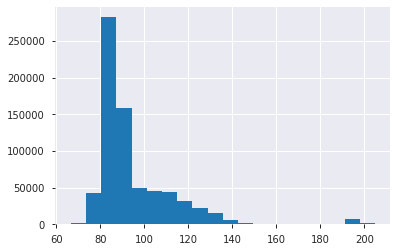


The highest feature correlations:
Correlation for feature distance and target: Pearson -0.7051214851558885, Spearman -0.49533777368585336
Correlation for feature size and target: Pearson -0.34281091966691324, Spearman -0.39868118970991123
Correlation for feature connections_1 and target: Pearson -0.39428655255888867, Spearman -0.3465737454411275
Correlation for feature gravity and target: Pearson 0.7166028399866796, Spearman 0.49533777368585336
Correlation for feature degree_y and target: Pearson -0.7823621501092408, Spearman -0.47328107124517055
Correlation for feature hybridization_y and target: Pearson -0.7825365499811407, Spearman -0.4734311508963898
Correlation for feature inring3_y and target: Pearson 0.3821923668221572, Spearman 0.49851800416086006
Correlation for feature nb_h_y and target: Pearson -0.5381649081119362, Spearman -0.5397521608920094
Correlation for feature delta and target: Pearson 0.4210097371453389, Spearman 0.4031918414166511

Scatter plot of distance and targ

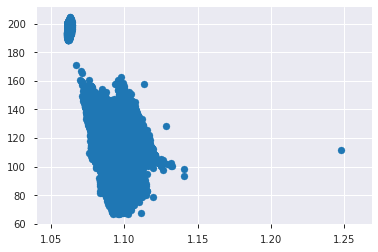

Scatter plot of size and target


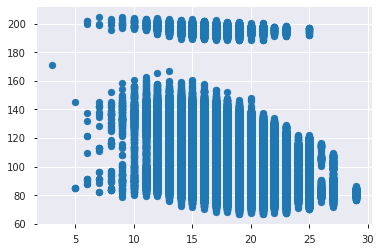

Scatter plot of connections_1 and target


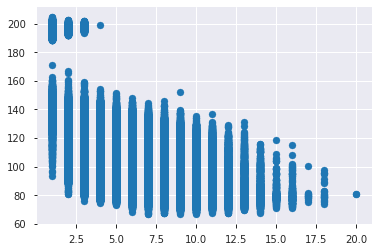

Scatter plot of gravity and target


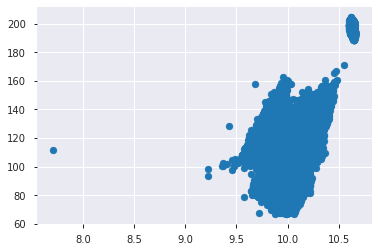

Scatter plot of degree_y and target


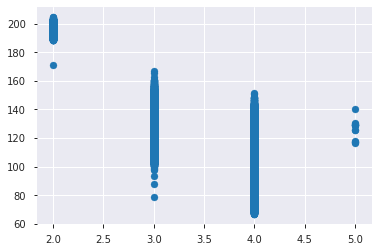

Scatter plot of hybridization_y and target


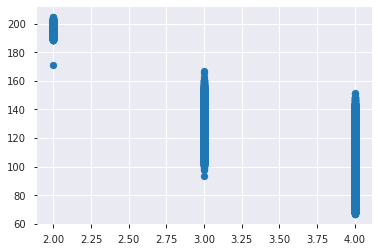

Scatter plot of inring3_y and target


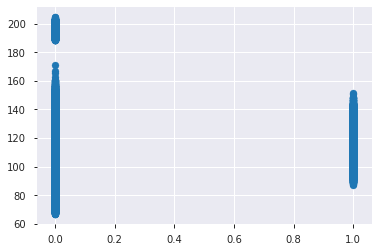

Scatter plot of nb_h_y and target


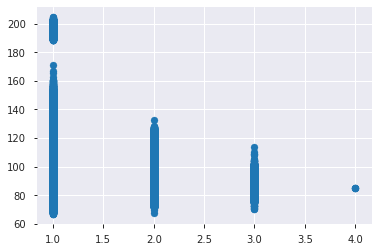

Scatter plot of delta and target


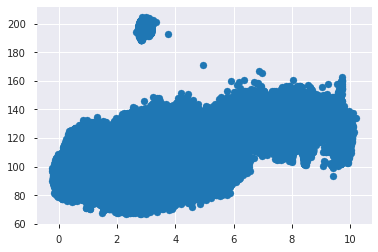

In [141]:
type_report(train_df, 0)

### 1JHN

Distribution of the target variable:


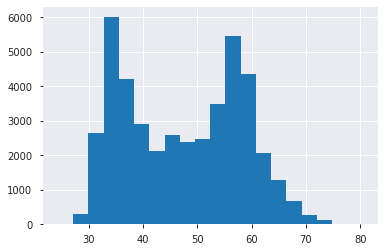


The highest feature correlations:
Correlation for feature distance and target: Pearson -0.8588319154454735, Spearman -0.9020673559571857
Correlation for feature gravity and target: Pearson 0.8670090656407792, Spearman 0.9020673559571857
Correlation for feature degree_y and target: Pearson 0.44644612423671387, Spearman 0.45370951486167255
Correlation for feature hybridization_y and target: Pearson -0.5966284605134029, Spearman -0.5697302802889657
Correlation for feature inring3_y and target: Pearson -0.47436992852856597, Spearman -0.4810889723542561
Correlation for feature inring5_y and target: Pearson 0.46219370260297554, Spearman 0.4672706434168812
Correlation for feature nb_n_y and target: Pearson 0.41263943305656337, Spearman 0.3862830397818407
Correlation for feature C H and target: Pearson -0.38259371803541664, Spearman -0.3972511971726805

Scatter plot of distance and target


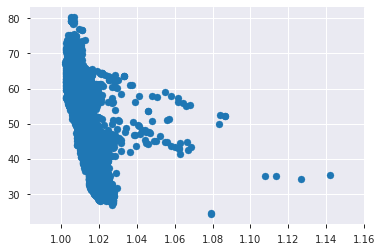

Scatter plot of gravity and target


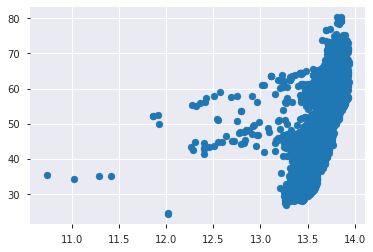

Scatter plot of degree_y and target


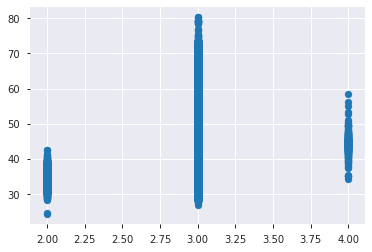

Scatter plot of hybridization_y and target


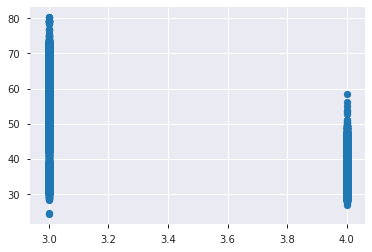

Scatter plot of inring3_y and target


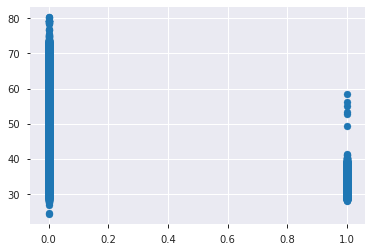

Scatter plot of inring5_y and target


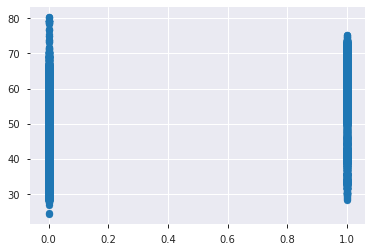

Scatter plot of nb_n_y and target


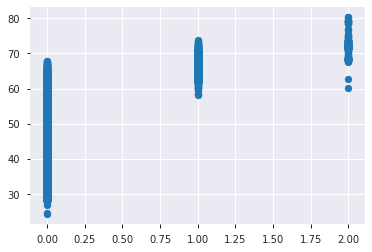

Scatter plot of C H and target


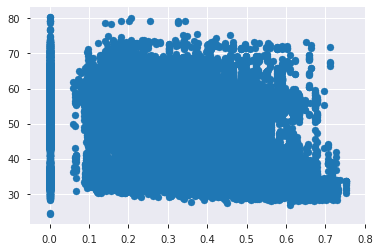

In [142]:
type_report(train_df, 1)

### 2JHH

Distribution of the target variable:


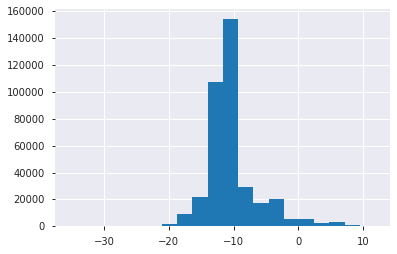


The highest feature correlations:
Correlation for feature distance and target: Pearson 0.5322463104101718, Spearman 0.6888563800350999
Correlation for feature gravity and target: Pearson -0.4924674722848764, Spearman -0.6888563800350999

Scatter plot of distance and target


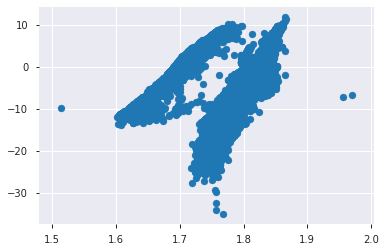

Scatter plot of gravity and target


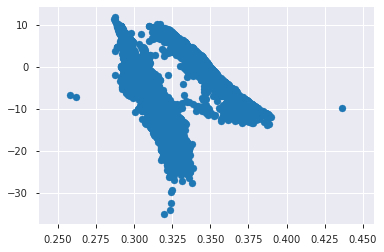

In [143]:
type_report(train_df, 2)

### 2JHN

Distribution of the target variable:


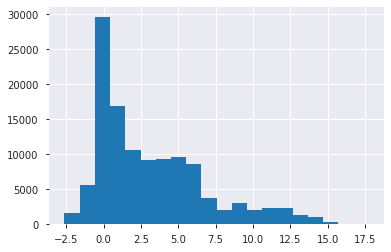


The highest feature correlations:
Correlation for feature mean_distance_0 and target: Pearson 0.3269997555093145, Spearman 0.41922029541520467
Correlation for feature degree_y and target: Pearson -0.34546441726307126, Spearman -0.24380506701854587
Correlation for feature inring_y and target: Pearson 0.2468838061959806, Spearman 0.30982673179318876

Scatter plot of mean_distance_0 and target


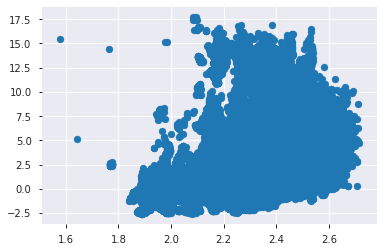

Scatter plot of degree_y and target


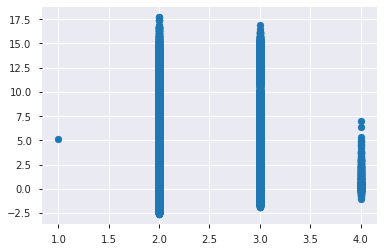

Scatter plot of inring_y and target


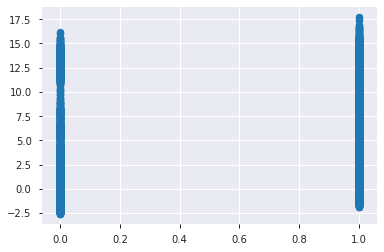

In [144]:
type_report(train_df, 3, corr_threshold=0.2)

### 2JHC

Distribution of the target variable:


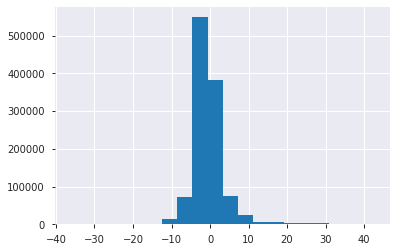


The highest feature correlations:
Correlation for feature distance and target: Pearson 0.2872530646062482, Spearman 0.42662145800388607
Correlation for feature gravity and target: Pearson -0.2771953244854112, Spearman -0.42662145800388607

Scatter plot of distance and target


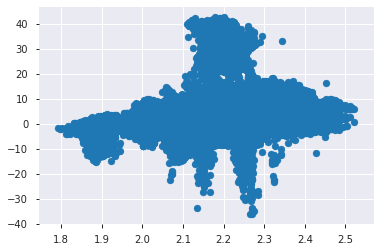

Scatter plot of gravity and target


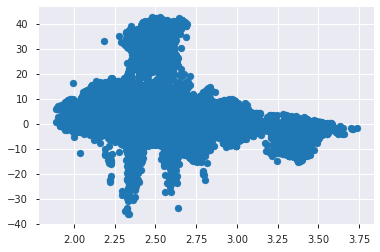

In [145]:
type_report(train_df, 4, corr_threshold=0.2)

### 3JHH

Distribution of the target variable:


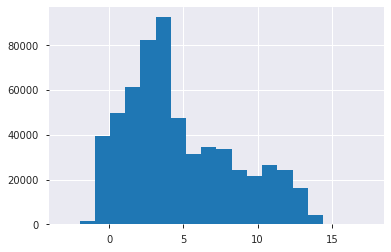


The highest feature correlations:
Correlation for feature mean_distance_0 and target: Pearson -0.2577481064809377, Spearman -0.2664338858903963

Scatter plot of mean_distance_0 and target


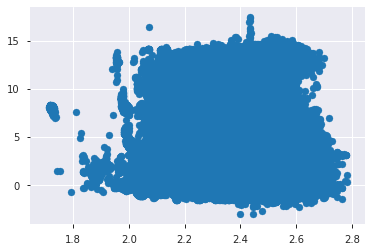

In [146]:
type_report(train_df, 5, corr_threshold=0.2)

### 3JHC

Distribution of the target variable:


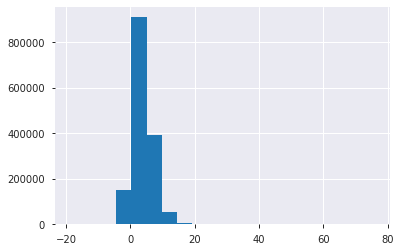


The highest feature correlations:
Correlation for feature distance and target: Pearson 0.3196697255180308, Spearman 0.2998921868346927
Correlation for feature gravity and target: Pearson -0.28754626693238183, Spearman -0.2998921868346927

Scatter plot of distance and target


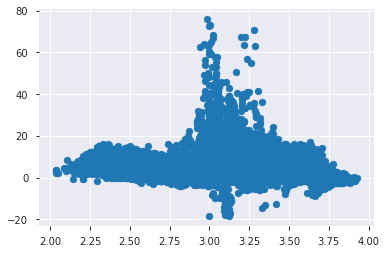

Scatter plot of gravity and target


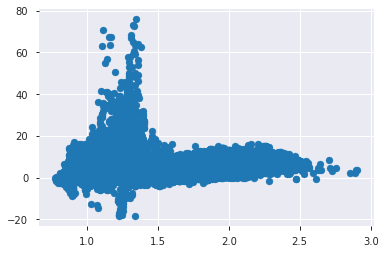

In [147]:
type_report(train_df, 6, corr_threshold=0.2)

### 3JHN

Distribution of the target variable:


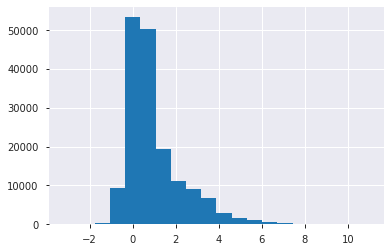


The highest feature correlations:
Correlation for feature distance and target: Pearson 0.27062032457089047, Spearman 0.22609202030040754
Correlation for feature gravity and target: Pearson -0.2496024265690058, Spearman -0.22609202030040754

Scatter plot of distance and target


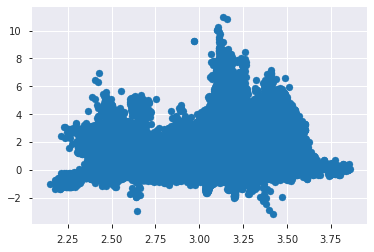

Scatter plot of gravity and target


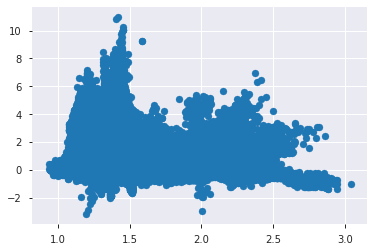

In [148]:
type_report(train_df, 7, corr_threshold=0.2)

After looking at the correlations, we should say that for most of the types (except the first 2) it is hard to find any features that are strongly correlated with the target, although the **distance** feature seems to be the most correlated in all cases.

# Evaluating functions

We will be using a custom evaluating function, which calculates the mean log MAE across the types.

In [183]:
def evaluate(y_true, predicted_df):
    predicted_df['scalar_coupling_constant'] = abs(predicted_df['scalar_coupling_constant'] - y_true)
    return np.log(predicted_df.groupby('type')['scalar_coupling_constant'].mean()).sum() / predicted_df['type'].nunique()


def feature_importances(model, feature_fields):
    return pd.DataFrame({
        'feature': feature_fields,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)


champs_scorer = make_scorer(evaluate, greater_is_better=False)

# Modeling

## Single LGBMRegressor model

In [99]:
class CHAMPS_LGBMRegressor(LGBMRegressor):
    def predict(self, X, **kwargs):
        scores = super().predict(X, **kwargs)
        return pd.DataFrame({
            'type': X['type'],
            'score': scores
        })

In [150]:
feature_fields = [col for col in train_df.columns if col not in ['id', 'atom_index_0', 'atom_index_1', 'scalar_coupling_constant', 'molecule_name', 'atom_0']]
X_train = train_df[feature_fields]
y_train = train_df['scalar_coupling_constant']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model = CHAMPS_LGBMRegressor(n_estimators=10000, learning_rate=0.5, early_stopping_rounds=20, reg_alpha=2.0)
model.fit(X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae')

predictions = model.predict(X_test)
print(evaluate(y_test, predictions))

Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 4.03309	training's l1: 1.3879	valid_1's l2: 4.09173	valid_1's l1: 1.39796
[200]	training's l2: 3.44248	training's l1: 1.27492	valid_1's l2: 3.55109	valid_1's l1: 1.29046
[300]	training's l2: 3.12915	training's l1: 1.21059	valid_1's l2: 3.27751	valid_1's l1: 1.2318
[400]	training's l2: 2.92167	training's l1: 1.16801	valid_1's l2: 3.1157	valid_1's l1: 1.19537
[500]	training's l2: 2.75415	training's l1: 1.13405	valid_1's l2: 2.98896	valid_1's l1: 1.16735
[600]	training's l2: 2.62355	training's l1: 1.10623	valid_1's l2: 2.89463	valid_1's l1: 1.14502
[700]	training's l2: 2.52	training's l1: 1.0855	valid_1's l2: 2.82651	valid_1's l1: 1.12988
[800]	training's l2: 2.42023	training's l1: 1.06439	valid_1's l2: 2.76096	valid_1's l1: 1.11431
[900]	training's l2: 2.33578	training's l1: 1.04618	valid_1's l2: 2.70784	valid_1's l1: 1.10126
[1000]	training's l2: 2.26987	training's l1: 1.03193	valid_1's l2: 2.67105	valid_

In [151]:
param_grid = {
    'n_estimators': [10000],
    'colsample_bytree': [1, 0.7],
    'learning_rate': [0.5, 0.75],
    'reg_alpha': [1.0, 2.0],
    'reg_lambda': [1.0, 2.0],
    'early_stopping_rounds': [20]
}

gridsearch = GridSearchCV(CHAMPS_LGBMRegressor(), scoring=champs_scorer, param_grid=param_grid, verbose=10, cv=2)

In [152]:
model = gridsearch.fit(X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae')

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] colsample_bytree=1, early_stopping_rounds=20, learning_rate=0.5, n_estimators=10000, reg_alpha=1.0, reg_lambda=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.07247	valid_0's l1: 1.39296	valid_1's l2: 4.13157	valid_1's l1: 1.40324
[200]	valid_0's l2: 3.51416	valid_0's l1: 1.28369	valid_1's l2: 3.61987	valid_1's l1: 1.30039
[300]	valid_0's l2: 3.22297	valid_0's l1: 1.22309	valid_1's l2: 3.3705	valid_1's l1: 1.24598
[400]	valid_0's l2: 3.04427	valid_0's l1: 1.18684	valid_1's l2: 3.22712	valid_1's l1: 1.21524
[500]	valid_0's l2: 2.91164	valid_0's l1: 1.15883	valid_1's l2: 3.13538	valid_1's l1: 1.19368
[600]	valid_0's l2: 2.8074	valid_0's l1: 1.13663	valid_1's l2: 3.06909	valid_1's l1: 1.17733
[700]	valid_0's l2: 2.73342	valid_0's l1: 1.12013	valid_1's l2: 3.02346	valid_1's l1: 1.16588
[800]	valid_0's l2: 2.65547	valid_0's l1: 1.10178	valid_1's l2: 2.97208	valid_1's l1: 1.15233
[900]	valid_0's l2: 2.59173	valid_0's l1: 1.08801	valid_1's l2: 2.93489	valid_1's l1: 1.14338
[1000]	valid_0's l2: 2.53515	valid_0's l1: 1.07572	valid_1's l2: 2.90137	valid_1's l1: 1.1356


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.1min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.06881	valid_0's l1: 1.39184	valid_1's l2: 4.12385	valid_1's l1: 1.40238
[200]	valid_0's l2: 3.50655	valid_0's l1: 1.28159	valid_1's l2: 3.61015	valid_1's l1: 1.29773
[300]	valid_0's l2: 3.23177	valid_0's l1: 1.22531	valid_1's l2: 3.38135	valid_1's l1: 1.24763
[400]	valid_0's l2: 3.04383	valid_0's l1: 1.18563	valid_1's l2: 3.23277	valid_1's l1: 1.21439
[500]	valid_0's l2: 2.90146	valid_0's l1: 1.15583	valid_1's l2: 3.12674	valid_1's l1: 1.19017
[600]	valid_0's l2: 2.79876	valid_0's l1: 1.13365	valid_1's l2: 3.05601	valid_1's l1: 1.17311
[700]	valid_0's l2: 2.7102	valid_0's l1: 1.11552	valid_1's l2: 3.00133	valid_1's l1: 1.16074
[800]	valid_0's l2: 2.64129	valid_0's l1: 1.10065	valid_1's l2: 2.9626	valid_1's l1: 1.15152
[900]	valid_0's l2: 2.57996	valid_0's l1: 1.08712	valid_1's l2: 2.92887	valid_1's l1: 1.143
[1000]	valid_0's l2: 2.52343	valid_0's l1: 1.07485	valid_1's l2: 2.90036	valid_1's l1: 1.13593
[

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.4min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.04202	valid_0's l1: 1.38845	valid_1's l2: 4.09365	valid_1's l1: 1.39646
[200]	valid_0's l2: 3.49957	valid_0's l1: 1.2835	valid_1's l2: 3.60024	valid_1's l1: 1.29824
[300]	valid_0's l2: 3.22164	valid_0's l1: 1.22387	valid_1's l2: 3.35919	valid_1's l1: 1.24416
[400]	valid_0's l2: 3.03789	valid_0's l1: 1.18659	valid_1's l2: 3.21778	valid_1's l1: 1.21296
[500]	valid_0's l2: 2.9028	valid_0's l1: 1.15803	valid_1's l2: 3.11669	valid_1's l1: 1.18998
[600]	valid_0's l2: 2.79694	valid_0's l1: 1.13598	valid_1's l2: 3.0383	valid_1's l1: 1.17305
[700]	valid_0's l2: 2.70727	valid_0's l1: 1.11654	valid_1's l2: 2.97918	valid_1's l1: 1.15861
[800]	valid_0's l2: 2.63126	valid_0's l1: 1.09917	valid_1's l2: 2.93006	valid_1's l1: 1.14616
[900]	valid_0's l2: 2.56474	valid_0's l1: 1.08416	valid_1's l2: 2.89145	valid_1's l1: 1.13624
[1000]	valid_0's l2: 2.51495	valid_0's l1: 1.07372	valid_1's l2: 2.86797	valid_1's l1: 1.13065


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.1min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.08844	valid_0's l1: 1.39879	valid_1's l2: 4.13807	valid_1's l1: 1.40692
[200]	valid_0's l2: 3.53232	valid_0's l1: 1.28945	valid_1's l2: 3.62693	valid_1's l1: 1.30388
[300]	valid_0's l2: 3.24257	valid_0's l1: 1.2289	valid_1's l2: 3.38066	valid_1's l1: 1.24952
[400]	valid_0's l2: 3.05955	valid_0's l1: 1.19041	valid_1's l2: 3.23811	valid_1's l1: 1.2173
[500]	valid_0's l2: 2.92117	valid_0's l1: 1.16203	valid_1's l2: 3.13796	valid_1's l1: 1.19494
[600]	valid_0's l2: 2.80299	valid_0's l1: 1.13585	valid_1's l2: 3.05102	valid_1's l1: 1.17381
[700]	valid_0's l2: 2.72064	valid_0's l1: 1.11856	valid_1's l2: 2.99779	valid_1's l1: 1.16161
[800]	valid_0's l2: 2.64425	valid_0's l1: 1.10257	valid_1's l2: 2.95144	valid_1's l1: 1.15083
[900]	valid_0's l2: 2.57526	valid_0's l1: 1.08818	valid_1's l2: 2.9142	valid_1's l1: 1.14203
[1000]	valid_0's l2: 2.51823	valid_0's l1: 1.0749	valid_1's l2: 2.88162	valid_1's l1: 1.13369
[

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 18.8min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.07874	valid_0's l1: 1.39351	valid_1's l2: 4.12015	valid_1's l1: 1.40231
[200]	valid_0's l2: 3.49934	valid_0's l1: 1.27838	valid_1's l2: 3.59092	valid_1's l1: 1.2938
[300]	valid_0's l2: 3.22539	valid_0's l1: 1.22248	valid_1's l2: 3.36263	valid_1's l1: 1.24416
[400]	valid_0's l2: 3.04799	valid_0's l1: 1.18749	valid_1's l2: 3.23232	valid_1's l1: 1.21578
[500]	valid_0's l2: 2.90882	valid_0's l1: 1.15717	valid_1's l2: 3.12693	valid_1's l1: 1.19091
[600]	valid_0's l2: 2.80124	valid_0's l1: 1.13532	valid_1's l2: 3.05456	valid_1's l1: 1.17495
[700]	valid_0's l2: 2.71865	valid_0's l1: 1.11767	valid_1's l2: 3.00234	valid_1's l1: 1.16248
[800]	valid_0's l2: 2.64464	valid_0's l1: 1.10096	valid_1's l2: 2.95763	valid_1's l1: 1.15099
[900]	valid_0's l2: 2.57799	valid_0's l1: 1.08621	valid_1's l2: 2.9187	valid_1's l1: 1.1414
[1000]	valid_0's l2: 2.51947	valid_0's l1: 1.07318	valid_1's l2: 2.88447	valid_1's l1: 1.13306


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.9min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.00429	valid_0's l1: 1.38076	valid_1's l2: 4.06096	valid_1's l1: 1.39054
[200]	valid_0's l2: 3.46101	valid_0's l1: 1.27341	valid_1's l2: 3.57241	valid_1's l1: 1.28959
[300]	valid_0's l2: 3.20932	valid_0's l1: 1.22136	valid_1's l2: 3.36398	valid_1's l1: 1.24382
[400]	valid_0's l2: 3.01604	valid_0's l1: 1.17947	valid_1's l2: 3.20731	valid_1's l1: 1.20734
[500]	valid_0's l2: 2.88965	valid_0's l1: 1.15294	valid_1's l2: 3.11647	valid_1's l1: 1.18597
[600]	valid_0's l2: 2.7759	valid_0's l1: 1.1286	valid_1's l2: 3.03319	valid_1's l1: 1.16697
[700]	valid_0's l2: 2.68385	valid_0's l1: 1.10836	valid_1's l2: 2.971	valid_1's l1: 1.15212
[800]	valid_0's l2: 2.61508	valid_0's l1: 1.09414	valid_1's l2: 2.9321	valid_1's l1: 1.14321
[900]	valid_0's l2: 2.5521	valid_0's l1: 1.07918	valid_1's l2: 2.89563	valid_1's l1: 1.13334
[1000]	valid_0's l2: 2.50096	valid_0's l1: 1.06806	valid_1's l2: 2.87192	valid_1's l1: 1.12738
[11

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 29.3min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.12846	valid_0's l1: 1.40103	valid_1's l2: 4.17293	valid_1's l1: 1.41049
[200]	valid_0's l2: 3.51075	valid_0's l1: 1.27976	valid_1's l2: 3.60767	valid_1's l1: 1.29554
[300]	valid_0's l2: 3.22014	valid_0's l1: 1.22183	valid_1's l2: 3.36524	valid_1's l1: 1.24392
[400]	valid_0's l2: 3.06268	valid_0's l1: 1.18906	valid_1's l2: 3.24375	valid_1's l1: 1.21663
[500]	valid_0's l2: 2.92142	valid_0's l1: 1.15994	valid_1's l2: 3.13723	valid_1's l1: 1.19331
[600]	valid_0's l2: 2.81124	valid_0's l1: 1.13626	valid_1's l2: 3.05944	valid_1's l1: 1.17513
[700]	valid_0's l2: 2.71513	valid_0's l1: 1.11482	valid_1's l2: 2.99153	valid_1's l1: 1.15866
[800]	valid_0's l2: 2.64539	valid_0's l1: 1.10034	valid_1's l2: 2.95063	valid_1's l1: 1.14919
[900]	valid_0's l2: 2.58816	valid_0's l1: 1.08844	valid_1's l2: 2.92299	valid_1's l1: 1.14253
[1000]	valid_0's l2: 2.52747	valid_0's l1: 1.07535	valid_1's l2: 2.8878	valid_1's l1: 1.1339

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 35.3min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.08425	valid_0's l1: 1.39442	valid_1's l2: 4.13947	valid_1's l1: 1.4044
[200]	valid_0's l2: 3.54518	valid_0's l1: 1.28862	valid_1's l2: 3.65373	valid_1's l1: 1.30479
[300]	valid_0's l2: 3.23351	valid_0's l1: 1.22587	valid_1's l2: 3.39193	valid_1's l1: 1.24842
[400]	valid_0's l2: 3.05674	valid_0's l1: 1.18991	valid_1's l2: 3.25812	valid_1's l1: 1.21844
[500]	valid_0's l2: 2.92104	valid_0's l1: 1.16367	valid_1's l2: 3.15664	valid_1's l1: 1.19781
[600]	valid_0's l2: 2.80334	valid_0's l1: 1.13851	valid_1's l2: 3.07207	valid_1's l1: 1.17833
[700]	valid_0's l2: 2.71878	valid_0's l1: 1.11974	valid_1's l2: 3.01553	valid_1's l1: 1.16449
[800]	valid_0's l2: 2.64291	valid_0's l1: 1.10355	valid_1's l2: 2.97116	valid_1's l1: 1.15356
[900]	valid_0's l2: 2.58627	valid_0's l1: 1.09159	valid_1's l2: 2.94248	valid_1's l1: 1.14664
[1000]	valid_0's l2: 2.52763	valid_0's l1: 1.07822	valid_1's l2: 2.90838	valid_1's l1: 1.1381

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 40.8min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 3.96689	valid_0's l1: 1.36526	valid_1's l2: 4.04907	valid_1's l1: 1.37849
[200]	valid_0's l2: 3.49642	valid_0's l1: 1.27693	valid_1's l2: 3.66098	valid_1's l1: 1.3011
[300]	valid_0's l2: 3.23074	valid_0's l1: 1.2217	valid_1's l2: 3.46043	valid_1's l1: 1.25505
[400]	valid_0's l2: 3.0769	valid_0's l1: 1.19232	valid_1's l2: 3.36582	valid_1's l1: 1.23393
[500]	valid_0's l2: 2.95962	valid_0's l1: 1.16858	valid_1's l2: 3.2969	valid_1's l1: 1.21823
[600]	valid_0's l2: 2.85517	valid_0's l1: 1.1463	valid_1's l2: 3.23619	valid_1's l1: 1.20322
[700]	valid_0's l2: 2.77995	valid_0's l1: 1.13095	valid_1's l2: 3.20868	valid_1's l1: 1.19603
[800]	valid_0's l2: 2.71558	valid_0's l1: 1.11708	valid_1's l2: 3.18281	valid_1's l1: 1.18904
[900]	valid_0's l2: 2.66564	valid_0's l1: 1.10615	valid_1's l2: 3.16968	valid_1's l1: 1.18522
Early stopping, best iteration is:
[947]	valid_0's l2: 2.64653	valid_0's l1: 1.1018	valid_1's l2:

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 43.5min remaining:    0.0s


Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.06363	valid_0's l1: 1.38472	valid_1's l2: 4.1373	valid_1's l1: 1.39581
[200]	valid_0's l2: 3.58015	valid_0's l1: 1.29437	valid_1's l2: 3.73439	valid_1's l1: 1.31555
[300]	valid_0's l2: 3.31135	valid_0's l1: 1.24216	valid_1's l2: 3.53267	valid_1's l1: 1.27262
[400]	valid_0's l2: 3.12212	valid_0's l1: 1.20407	valid_1's l2: 3.40181	valid_1's l1: 1.2422
[500]	valid_0's l2: 2.98449	valid_0's l1: 1.17519	valid_1's l2: 3.314	valid_1's l1: 1.22142
[600]	valid_0's l2: 2.89953	valid_0's l1: 1.15807	valid_1's l2: 3.27568	valid_1's l1: 1.21234
[700]	valid_0's l2: 2.82088	valid_0's l1: 1.1421	valid_1's l2: 3.23858	valid_1's l1: 1.20428
Early stopping, best iteration is:
[688]	valid_0's l2: 2.82585	valid_0's l1: 1.14298	valid_1's l2: 3.23772	valid_1's l1: 1.20429
[CV]  colsample_bytree=1, early_stopping_rounds=20, learning_rate=0.75, n_estimators=10000, reg_alpha=1.0, reg_lambda=1.0, score=-0.099, total= 2.1min
[CV] 

[CV]  colsample_bytree=1, early_stopping_rounds=20, learning_rate=0.75, n_estimators=10000, reg_alpha=2.0, reg_lambda=2.0, score=-0.084, total= 3.1min
[CV] colsample_bytree=0.7, early_stopping_rounds=20, learning_rate=0.5, n_estimators=10000, reg_alpha=1.0, reg_lambda=1.0 
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.27838	valid_0's l1: 1.43419	valid_1's l2: 4.32813	valid_1's l1: 1.44329
[200]	valid_0's l2: 3.67898	valid_0's l1: 1.31789	valid_1's l2: 3.77978	valid_1's l1: 1.33379
[300]	valid_0's l2: 3.40464	valid_0's l1: 1.26259	valid_1's l2: 3.54729	valid_1's l1: 1.28477
[400]	valid_0's l2: 3.19341	valid_0's l1: 1.22054	valid_1's l2: 3.37603	valid_1's l1: 1.24817
[500]	valid_0's l2: 3.06605	valid_0's l1: 1.19463	valid_1's l2: 3.285	valid_1's l1: 1.22827
[600]	valid_0's l2: 2.94497	valid_0's l1: 1.17055	valid_1's l2: 3.19994	valid_1's l1: 1.20912
[700]	valid_0's l2: 2.84598	valid_0's l1: 1.14954	valid_1's l2: 3.13024	valid_1's l1: 1.19307
[800]	va

[900]	valid_0's l2: 2.70689	valid_0's l1: 1.11896	valid_1's l2: 3.04656	valid_1's l1: 1.17172
[1000]	valid_0's l2: 2.64215	valid_0's l1: 1.10439	valid_1's l2: 3.00486	valid_1's l1: 1.16169
[1100]	valid_0's l2: 2.59214	valid_0's l1: 1.09309	valid_1's l2: 2.97687	valid_1's l1: 1.15473
[1200]	valid_0's l2: 2.53007	valid_0's l1: 1.07929	valid_1's l2: 2.93694	valid_1's l1: 1.14569
Early stopping, best iteration is:
[1223]	valid_0's l2: 2.52268	valid_0's l1: 1.07758	valid_1's l2: 2.93416	valid_1's l1: 1.14496
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, learning_rate=0.5, n_estimators=10000, reg_alpha=1.0, reg_lambda=2.0, score=-0.029, total= 3.0min
[CV] colsample_bytree=0.7, early_stopping_rounds=20, learning_rate=0.5, n_estimators=10000, reg_alpha=2.0, reg_lambda=1.0 
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.27171	valid_0's l1: 1.43626	valid_1's l2: 4.3162	valid_1's l1: 1.44464
[200]	valid_0's l2: 3.73377	valid_0's l1: 1.33102	valid_1's l

[1000]	valid_0's l2: 2.63226	valid_0's l1: 1.10124	valid_1's l2: 2.99261	valid_1's l1: 1.1582
[1100]	valid_0's l2: 2.5793	valid_0's l1: 1.09002	valid_1's l2: 2.965	valid_1's l1: 1.15154
[1200]	valid_0's l2: 2.53172	valid_0's l1: 1.07923	valid_1's l2: 2.94092	valid_1's l1: 1.14535
[1300]	valid_0's l2: 2.48767	valid_0's l1: 1.06896	valid_1's l2: 2.91495	valid_1's l1: 1.13915
[1400]	valid_0's l2: 2.44936	valid_0's l1: 1.06029	valid_1's l2: 2.89787	valid_1's l1: 1.13476
[1500]	valid_0's l2: 2.41331	valid_0's l1: 1.05166	valid_1's l2: 2.88215	valid_1's l1: 1.13022
[1600]	valid_0's l2: 2.38197	valid_0's l1: 1.04419	valid_1's l2: 2.86883	valid_1's l1: 1.1265
[1700]	valid_0's l2: 2.35086	valid_0's l1: 1.03672	valid_1's l2: 2.85522	valid_1's l1: 1.12316
[1800]	valid_0's l2: 2.32214	valid_0's l1: 1.03026	valid_1's l2: 2.84599	valid_1's l1: 1.121
[1900]	valid_0's l2: 2.29956	valid_0's l1: 1.02503	valid_1's l2: 2.83987	valid_1's l1: 1.11948
[2000]	valid_0's l2: 2.27052	valid_0's l1: 1.01803	valid_

Early stopping, best iteration is:
[865]	valid_0's l2: 2.7715	valid_0's l1: 1.13217	valid_1's l2: 3.23977	valid_1's l1: 1.20579
[CV]  colsample_bytree=0.7, early_stopping_rounds=20, learning_rate=0.75, n_estimators=10000, reg_alpha=2.0, reg_lambda=1.0, score=-0.106, total= 2.4min
[CV] colsample_bytree=0.7, early_stopping_rounds=20, learning_rate=0.75, n_estimators=10000, reg_alpha=2.0, reg_lambda=1.0 
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 4.21974	valid_0's l1: 1.41399	valid_1's l2: 4.3045	valid_1's l1: 1.42655
[200]	valid_0's l2: 3.65977	valid_0's l1: 1.31136	valid_1's l2: 3.81674	valid_1's l1: 1.33357
[300]	valid_0's l2: 3.39501	valid_0's l1: 1.25915	valid_1's l2: 3.61776	valid_1's l1: 1.29029
[400]	valid_0's l2: 3.2129	valid_0's l1: 1.22404	valid_1's l2: 3.48507	valid_1's l1: 1.2625
[500]	valid_0's l2: 3.11018	valid_0's l1: 1.20454	valid_1's l2: 3.43758	valid_1's l1: 1.25154
[600]	valid_0's l2: 3.02158	valid_0's l1: 1.1867	valid_1's l2: 3.3

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 116.5min finished


Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 4.03438	training's l1: 1.38931	valid_1's l2: 4.0834	valid_1's l1: 1.39815
[200]	training's l2: 3.44111	training's l1: 1.27444	valid_1's l2: 3.55049	valid_1's l1: 1.28931
[300]	training's l2: 3.12699	training's l1: 1.21097	valid_1's l2: 3.27822	valid_1's l1: 1.23166
[400]	training's l2: 2.90136	training's l1: 1.1651	valid_1's l2: 3.09287	valid_1's l1: 1.19151
[500]	training's l2: 2.7356	training's l1: 1.13148	valid_1's l2: 2.96667	valid_1's l1: 1.16387
[600]	training's l2: 2.60722	training's l1: 1.10413	valid_1's l2: 2.87659	valid_1's l1: 1.14231
[700]	training's l2: 2.51099	training's l1: 1.08286	valid_1's l2: 2.81075	valid_1's l1: 1.12609
[800]	training's l2: 2.41959	training's l1: 1.06333	valid_1's l2: 2.75032	valid_1's l1: 1.11167
[900]	training's l2: 2.3423	training's l1: 1.04822	valid_1's l2: 2.70707	valid_1's l1: 1.10234
[1000]	training's l2: 2.26545	training's l1: 1.03106	valid_1's l2: 2.65461	val

In [153]:
evaluate(y_test, model.best_estimator_.predict(X_test))

-0.12465132188397451

In [154]:
model.best_params_

{'colsample_bytree': 1,
 'early_stopping_rounds': 20,
 'learning_rate': 0.5,
 'n_estimators': 10000,
 'reg_alpha': 2.0,
 'reg_lambda': 2.0}

In [157]:
feature_importances(model.best_estimator_, feature_fields)[:30]

,feature,importance
52,delta,13475
8,distance,11731
9,mean_distance_0,10442
10,mean_distance_1,7855
17,gravity,7738
20,z_0^2,4594
2,y_0,4577
19,y_0^2,4568
12,connections_0,4535
18,x_0^2,4531


In [179]:
import gc
gc.collect()

243

In [164]:
X_train = train_df[feature_fields]
y_train = train_df['scalar_coupling_constant']
X_test = test_df[feature_fields]
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#model = model.best_estimator_
model.fit(X_train, y_train, verbose=100, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae')

Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 4.13817	training's l1: 1.40447	valid_1's l2: 4.15849	valid_1's l1: 1.40629
[200]	training's l2: 3.48152	training's l1: 1.27525	valid_1's l2: 3.54408	valid_1's l1: 1.28144
[300]	training's l2: 3.1784	training's l1: 1.21413	valid_1's l2: 3.27547	valid_1's l1: 1.225
[400]	training's l2: 2.96903	training's l1: 1.17041	valid_1's l2: 3.0947	valid_1's l1: 1.18527
[500]	training's l2: 2.80358	training's l1: 1.13669	valid_1's l2: 2.95909	valid_1's l1: 1.15557
[600]	training's l2: 2.67156	training's l1: 1.10964	valid_1's l2: 2.85629	valid_1's l1: 1.13277
[700]	training's l2: 2.57046	training's l1: 1.08786	valid_1's l2: 2.77806	valid_1's l1: 1.11485
[800]	training's l2: 2.48058	training's l1: 1.06848	valid_1's l2: 2.71259	valid_1's l1: 1.09944
[900]	training's l2: 2.39879	training's l1: 1.0509	valid_1's l2: 2.65194	valid_1's l1: 1.08551
[1000]	training's l2: 2.32451	training's l1: 1.03503	valid_1's l2: 2.59735	vali

CHAMPS_LGBMRegressor(boosting_type='gbdt', class_weight=None,
                     colsample_bytree=1, early_stopping_rounds=20,
                     importance_type='split', learning_rate=0.5, max_depth=-1,
                     min_child_samples=20, min_child_weight=0.001,
                     min_split_gain=0.0, n_estimators=10000, n_jobs=-1,
                     num_leaves=31, objective=None, random_state=None,
                     reg_alpha=2.0, reg_lambda=2.0, silent=True, subsample=1.0,
                     subsample_for_bin=200000, subsample_freq=0)

In [165]:
predictions = model.predict(X_test)

In [170]:
predictions['id'] = test_df['id']
predictions = predictions.drop('type', axis=1)

In [171]:
predictions.to_csv('submission_new.csv', header=True, index=False)

**Kaggle result: -0.165** 

## Ensembling

### Model per each type

Let's try to use a couple of different ensembling techniques, first of all let's try to train a model per each type of connections and then combine the results.

In [193]:
class ModelPerType:
    def __init__(self, **lgbm_config):
        self.lgbm_config = lgbm_config
        self.model_dict = {}
    
    def fit(self, X, **lgbm_fit_params):
        types = X['type'].unique()
        self.feature_fields = [col for col in train_df.columns if col not in ['id', 'atom_index_0', 'atom_index_1', 'scalar_coupling_constant', 'molecule_name', 'atom_0', 'type', 'scalar_coupling_constant']]
        
        for type_name in types:
            X_train = X[X['type'] == type_name]
            y_train = X_train['scalar_coupling_constant']
            X_train = X_train[self.feature_fields]
            X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
            
            model = LGBMRegressor(**self.lgbm_config)
            print('Fitting model for type {}'.format(type_name))
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], **lgbm_fit_params)
            self.model_dict[type_name] = model
    
    def predict(self, X):
        predictions = None
        for type_name, model in self.model_dict.items():
            X_pred = X[X['type'] == type_name]
            type_score = pd.DataFrame({
                'id': X_pred['id'],
                'type': type_name,
                'scalar_coupling_constant': model.predict(X_pred[self.feature_fields])
            })
            if predictions is None:
                predictions = type_score
            else:
                predictions = pd.concat([predictions, type_score])
        return predictions.sort_values('id')

In [180]:
best_grid_params = {
    'colsample_bytree': 1,
    'early_stopping_rounds': 20,
    'learning_rate': 0.5,
    'n_estimators': 10000,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0
}

model = ModelPerType(**best_grid_params)
X_train, X_test = train_test_split(train_df, test_size=0.3, random_state=42)
model.fit(X_train, verbose=100, eval_metric='mae')

Fitting model for type 3
Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 0.534449	training's l1: 0.499893	valid_1's l2: 0.777299	valid_1's l1: 0.591006
[200]	training's l2: 0.346992	training's l1: 0.411232	valid_1's l2: 0.713073	valid_1's l1: 0.567332
Early stopping, best iteration is:
[265]	training's l2: 0.27853	training's l1: 0.371875	valid_1's l2: 0.695684	valid_1's l1: 0.559891
Fitting model for type 6
Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 2.45842	training's l1: 1.12078	valid_1's l2: 2.56933	valid_1's l1: 1.13479
[200]	training's l2: 2.05993	training's l1: 1.02045	valid_1's l2: 2.23155	valid_1's l1: 1.04803
[300]	training's l2: 1.85761	training's l1: 0.971112	valid_1's l2: 2.08558	valid_1's l1: 1.01161
[400]	training's l2: 1.70096	training's l1: 0.931688	valid_1's l2: 1.99039	valid_1's l1: 0.985355
[500]	training's l2: 1.57963	training's l1: 0.899299	valid_1's l2: 1.91978	valid_1's l1: 0.966289
[600]	t

[100]	training's l2: 0.211968	training's l1: 0.317221	valid_1's l2: 0.296154	valid_1's l1: 0.359859
[200]	training's l2: 0.148234	training's l1: 0.269111	valid_1's l2: 0.27251	valid_1's l1: 0.343912
[300]	training's l2: 0.111031	training's l1: 0.236314	valid_1's l2: 0.261156	valid_1's l1: 0.335657
[400]	training's l2: 0.0884992	training's l1: 0.213251	valid_1's l2: 0.256627	valid_1's l1: 0.332627
[500]	training's l2: 0.0716089	training's l1: 0.193488	valid_1's l2: 0.252823	valid_1's l1: 0.329807
Early stopping, best iteration is:
[559]	training's l2: 0.0637466	training's l1: 0.183516	valid_1's l2: 0.250374	valid_1's l1: 0.327953
Fitting model for type 1
Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 0.958937	training's l1: 0.724226	valid_1's l2: 2.20139	valid_1's l1: 1.0716
Early stopping, best iteration is:
[163]	training's l2: 0.612502	training's l1: 0.581853	valid_1's l2: 2.1283	valid_1's l1: 1.0553


In [191]:
X_test = X_test.sort_values('id')
predictions = model.predict(X_test)

In [192]:
evaluate(X_test['scalar_coupling_constant'], predictions)

-0.3206572720076211

Wow, outstanding result! Let's train this model on the whole data and send the predictions to kaggle.

In [194]:
model = ModelPerType(**best_grid_params)
model.fit(train_df, verbose=100, eval_metric='mae')

Fitting model for type 0
Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 7.67079	training's l1: 2.03719	valid_1's l2: 8.10597	valid_1's l1: 2.07871
[200]	training's l2: 6.54521	training's l1: 1.88293	valid_1's l2: 7.29051	valid_1's l1: 1.96471
[300]	training's l2: 5.8648	training's l1: 1.7842	valid_1's l2: 6.85844	valid_1's l1: 1.89986
[400]	training's l2: 5.35466	training's l1: 1.70725	valid_1's l2: 6.56676	valid_1's l1: 1.85479
[500]	training's l2: 5.0031	training's l1: 1.64858	valid_1's l2: 6.40674	valid_1's l1: 1.82712
[600]	training's l2: 4.68528	training's l1: 1.59729	valid_1's l2: 6.27166	valid_1's l1: 1.80586
[700]	training's l2: 4.42239	training's l1: 1.55369	valid_1's l2: 6.18348	valid_1's l1: 1.79101
[800]	training's l2: 4.18608	training's l1: 1.51273	valid_1's l2: 6.0941	valid_1's l1: 1.77589
[900]	training's l2: 3.9567	training's l1: 1.47404	valid_1's l2: 6.00733	valid_1's l1: 1.76245
[1000]	training's l2: 3.77828	training's l1: 1.44181	v

[1800]	training's l2: 0.283638	training's l1: 0.385087	valid_1's l2: 0.704101	valid_1's l1: 0.575575
[1900]	training's l2: 0.270939	training's l1: 0.376725	valid_1's l2: 0.7004	valid_1's l1: 0.573746
[2000]	training's l2: 0.25874	training's l1: 0.368787	valid_1's l2: 0.696596	valid_1's l1: 0.572236
[2100]	training's l2: 0.248102	training's l1: 0.361451	valid_1's l2: 0.694365	valid_1's l1: 0.571086
Early stopping, best iteration is:
[2138]	training's l2: 0.244239	training's l1: 0.358841	valid_1's l2: 0.69354	valid_1's l1: 0.570797
Fitting model for type 6
Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 2.47904	training's l1: 1.12589	valid_1's l2: 2.58913	valid_1's l1: 1.14239
[200]	training's l2: 2.0874	training's l1: 1.03102	valid_1's l2: 2.25397	valid_1's l1: 1.05812
[300]	training's l2: 1.89566	training's l1: 0.98183	valid_1's l2: 2.1027	valid_1's l1: 1.01832
[400]	training's l2: 1.74455	training's l1: 0.942205	valid_1's l2: 1.99026	valid_1's l1: 0.

In [195]:
predictions = model.predict(test_df)

In [197]:
predictions.drop('type', axis=1).to_csv('submission_model_per_type.csv', header=True, index=False)

**Kaggle result: -0.38**

### Model per set of features

Let's try to separate the data vertically: we will build a model per each of three types of features: RDKit ones, TF-IDF ones and original data-based.

In [198]:
train_df.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'atom_0', 'x_1', 'y_1',
       'z_1', 'atom_1', 'distance', 'mean_distance_0', 'mean_distance_1',
       'size', 'connections_0', 'connections_1', 'mass', 'atom_0_mass',
       'atom_1_mass', 'gravity', 'x_0^2', 'y_0^2', 'z_0^2', 'x_1^2', 'y_1^2',
       'z_1^2', 'degree_x', 'hybridization_x', 'inring_x', 'inring3_x',
       'inring4_x', 'inring5_x', 'inring6_x', 'inring7_x', 'inring8_x',
       'nb_h_x', 'nb_o_x', 'nb_c_x', 'nb_n_x', 'nb_na_x', 'degree_y',
       'hybridization_y', 'inring_y', 'inring3_y', 'inring4_y', 'inring5_y',
       'inring6_y', 'inring7_y', 'inring8_y', 'nb_h_y', 'nb_o_y', 'nb_c_y',
       'nb_n_y', 'nb_na_y', 'delta', 'C C', 'C F', 'C H', 'C N', 'C O', 'F C',
       'F F', 'F H', 'F N', 'F O', 'H C', 'H F', 'H H', 'H N', 'H O', 'N C',
       'N F', 'N H', 'N N', 'N O', 'O C', 'O F', 'O H', 'O N', 'O O'],
      dtype='object')

In [218]:
class ModelPerFeatureSet:
    def __init__(self, **lgbm_config):
        self.lgbm_config = lgbm_config
        self.model_dict = {}
        self.common_features = ['type', 'atom_1']
    
    def fit(self, X, **lgbm_fit_params):
        self.feature_fields = [col for col in train_df.columns if col not in ['id', 'atom_index_0', 'atom_index_1', 'scalar_coupling_constant', 'molecule_name', 'atom_0', 'scalar_coupling_constant']]
        tf_idf_features = [col for col in self.feature_fields if len(col) == 3 and col.upper() == col] + self.common_features
        rdkit_features = [col for col in self.feature_fields if col.startswith('nb') or col.startswith('inring') or col.startswith('degree') or col.startswith('hyb')] + self.common_features
        original_features = list(set(self.feature_fields) - set(tf_idf_features) - set(rdkit_features)) + self.common_features
        self.name_to_features = {
            'tf-idf': tf_idf_features,
            'rdkit': rdkit_features,
            'original': original_features
        }
        
        model_scores = pd.DataFrame(columns=[])
        X_train, X_valid, y_train, y_valid = train_test_split(X[self.feature_fields], X['scalar_coupling_constant'], test_size=0.2)
        for name, features in self.name_to_features.items():
            X_train_local = X_train[features]
            X_valid_local = X_valid[features]
            print('Fitting model {}'.format(name.upper()))
            print('This features will be used: {}'.format(features))
            model = LGBMRegressor(**self.lgbm_config)
            model.fit(X_train_local, y_train, eval_set=[(X_train_local, y_train), (X_valid_local, y_valid)], **lgbm_fit_params)
            print('Predicting model {}'.format(name.upper()))
            model_scores[name] = model.predict(X[features])
            
            self.model_dict[name] = model
        
        self.combining_model = LGBMRegressor(**self.lgbm_config)
        X_train, X_valid, y_train, y_valid = train_test_split(model_scores, X['scalar_coupling_constant'], test_size=0.2)
        print('Fitting combining model')
        self.combining_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], **lgbm_fit_params)
    
    def predict(self, X):
        model_scores = pd.DataFrame(columns=[])
        for name, features in self.name_to_features.items():
            print('Predicting model {}'.format(name.upper()))
            model_scores[name] = self.model_dict[name].predict(X[self.name_to_features[name]])
        print('Predicting combining model')
        return pd.DataFrame({
            'id': X['id'],
            'type': X['type'],
            'scalar_coupling_constant': self.combining_model.predict(model_scores)
        })
            

In [219]:
gc.collect()
best_grid_params = {
    'colsample_bytree': 1,
    'early_stopping_rounds': 20,
    'learning_rate': 0.5,
    'n_estimators': 10000,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0
}

model = ModelPerFeatureSet(**best_grid_params)
X_train, X_test = train_test_split(train_df, test_size=0.3, random_state=42)
model.fit(X_train, verbose=100, eval_metric='mae')

Fitting model TF-IDF
This features will be used: ['C C', 'C F', 'C H', 'C N', 'C O', 'F C', 'F F', 'F H', 'F N', 'F O', 'H C', 'H F', 'H H', 'H N', 'H O', 'N C', 'N F', 'N H', 'N N', 'N O', 'O C', 'O F', 'O H', 'O N', 'O O', 'type', 'atom_1']
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[74]	training's l2: 51.2867	training's l1: 3.87064	valid_1's l2: 51.7669	valid_1's l1: 3.8672
Predicting model TF-IDF
Fitting model RDKIT
This features will be used: ['degree_x', 'hybridization_x', 'inring_x', 'inring3_x', 'inring4_x', 'inring5_x', 'inring6_x', 'inring7_x', 'inring8_x', 'nb_h_x', 'nb_o_x', 'nb_c_x', 'nb_n_x', 'nb_na_x', 'degree_y', 'hybridization_y', 'inring_y', 'inring3_y', 'inring4_y', 'inring5_y', 'inring6_y', 'inring7_y', 'inring8_y', 'nb_h_y', 'nb_o_y', 'nb_c_y', 'nb_n_y', 'nb_na_y', 'type', 'atom_1']
Training until validation scores don't improve for 20 rounds.
[100]	training's l2: 14.098	training's l1: 2.63024	valid_1's l2: 14.0

In [220]:
predictions = model.predict(X_test)
evaluate(X_test['scalar_coupling_constant'], predictions)

Predicting model TF-IDF
Predicting model RDKIT
Predicting model ORIGINAL
Predicting combining model


0.03981890823899739

# Results

Results of the models we used are:

1. Single LGBMRegressor model for all data: -0.165 (Kaggle)
2. Ensemble of 8 LGBMRegressor models (one per each type of atom connection): -0.38 (Kaggle)
3. Ensemble of 3 LGBMRegressor models (one per each set of different features: TF-IDF features, RDKit features and original data features): 0.039 (training dataframe)

So the best result was provided by the per-type modeling approach.